<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementation of Variational AutoEncoder (VAE)

https://ar5iv.labs.arxiv.org/html/1312.6114


In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# 1. Load Dataset


In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 100
dataset_path = '~/datasets'

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


# 2. Define our model: Variational AutoEncoder (VAE)


In [3]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance
                                                       #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


In [5]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon
        z = mean + var*epsilon                          # reparameterization trick
        return z


    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var


In [6]:
# Model Hyperparameters
x_dim  = 784
hidden_dim = 400
latent_dim = 200

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
print(model)

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=784, out_features=400, bias=True)
    (FC_input2): Linear(in_features=400, out_features=400, bias=True)
    (FC_mean): Linear(in_features=400, out_features=200, bias=True)
    (FC_var): Linear(in_features=400, out_features=200, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=200, out_features=400, bias=True)
    (FC_hidden2): Linear(in_features=400, out_features=400, bias=True)
    (FC_output): Linear(in_features=400, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)


# 3. Define Loss function (reprod. loss) and optimizer


In [7]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)


# 4. Train Variational AutoEncoder (VAE)

In [8]:
print("Start training VAE...")
model.train()

epochs = 100

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")


Start training VAE...
	Epoch 1 complete! 	Average Loss:  174.45327430483096
	Epoch 2 complete! 	Average Loss:  128.95353152063333
	Epoch 3 complete! 	Average Loss:  116.99807053096306
	Epoch 4 complete! 	Average Loss:  112.41056456398685
	Epoch 5 complete! 	Average Loss:  109.99989539858097
	Epoch 6 complete! 	Average Loss:  108.46988700242592
	Epoch 7 complete! 	Average Loss:  107.31140675539963
	Epoch 8 complete! 	Average Loss:  106.33424741104966
	Epoch 9 complete! 	Average Loss:  105.54594609179361
	Epoch 10 complete! 	Average Loss:  104.84990464250313
	Epoch 11 complete! 	Average Loss:  104.29589620395973
	Epoch 12 complete! 	Average Loss:  103.85685251786832
	Epoch 13 complete! 	Average Loss:  103.48037993009181
	Epoch 14 complete! 	Average Loss:  103.10478734088063
	Epoch 15 complete! 	Average Loss:  102.8120355540484
	Epoch 16 complete! 	Average Loss:  102.53921904345785
	Epoch 17 complete! 	Average Loss:  102.31260174835664
	Epoch 18 complete! 	Average Loss:  102.0246276019929

#5. Generate images from test dataset


In [20]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break


  0%|          | 0/100 [00:00<?, ?it/s]


In [21]:
import matplotlib.pyplot as plt

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())


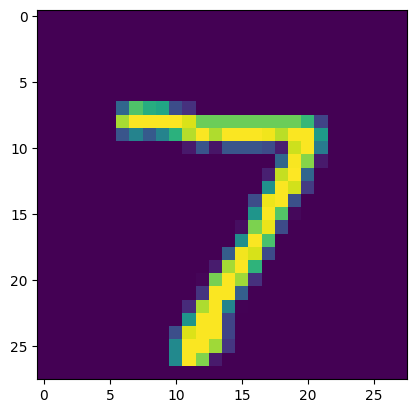

In [22]:
show_image(x, idx=0)


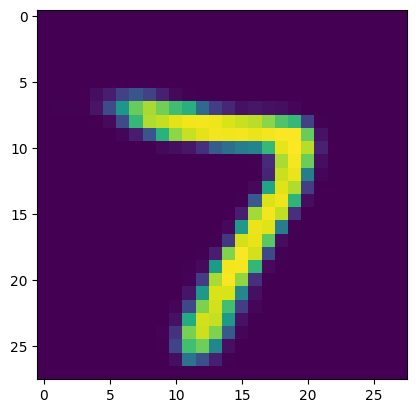

In [23]:
show_image(x_hat, idx=0)


# 6. Generate image from noise vector
Please note that this is not the correct generative process.

- Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

- To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.



In [24]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)


In [25]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')


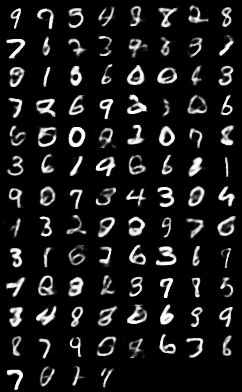

In [26]:
from IPython.display import Image
Image(filename='generated_sample.png')


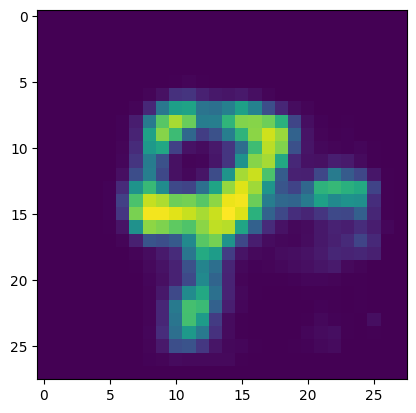

In [27]:
show_image(generated_images, idx=12)


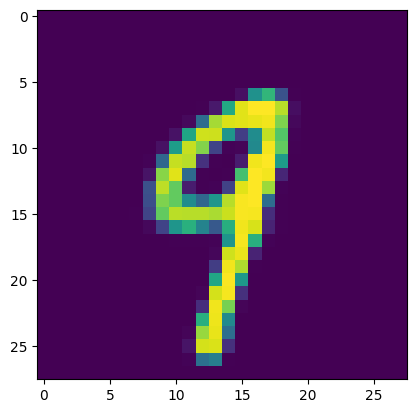

In [28]:
show_image(generated_images, idx=0)


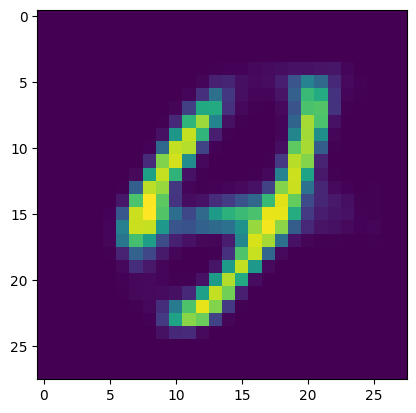

In [29]:
show_image(generated_images, idx=3)